In [1]:
!pip install deepxde

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 4.2 MB/s eta 0:00:0000:01


In [31]:
import deepxde as dde
dde.backend.set_default_backend("pytorch") 
from deepxde.backend import torch, backend_name

import numpy as np
import matplotlib.pyplot as plt

'''
"# DeepXDE will internally create tf.keras layers with these specs."
If there is any issue with torch.sin or other torch.###,
just replace it with tf.sin or tf.###.
'''

# # For reproducibility: fix all random seeds used by DeepXDE / TensorFlow backend
# dde.config.set_random_seed(1234)

Setting the default backend to "pytorch". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


'\n\n'

Compiling model...
'compile' took 0.004104 s

Training model...

Step      Train loss                        Test loss                         Test metric   
0         [7.76e+01, 1.11e+00, 4.45e-02]    [8.87e+01, 1.11e+00, 4.45e-02]    [1.35e+00]    
1000      [5.79e-03, 2.51e-03, 3.69e-03]    [1.67e-02, 2.51e-03, 3.69e-03]    [6.12e-01]    
2000      [1.27e-03, 4.26e-04, 1.87e-04]    [1.92e-02, 4.26e-04, 1.87e-04]    [6.08e-01]    
3000      [4.04e-04, 8.58e-05, 3.21e-05]    [1.96e-02, 8.58e-05, 3.21e-05]    [6.08e-01]    
4000      [2.57e-04, 6.51e-05, 5.85e-06]    [1.98e-02, 6.51e-05, 5.85e-06]    [6.08e-01]    
5000      [1.52e-03, 1.33e-04, 7.94e-04]    [2.09e-02, 1.33e-04, 7.94e-04]    [6.11e-01]    
6000      [1.11e-03, 1.04e-04, 7.61e-04]    [2.05e-02, 1.04e-04, 7.61e-04]    [6.11e-01]    
7000      [1.59e-03, 1.70e-04, 9.17e-04]    [2.19e-02, 1.70e-04, 9.17e-04]    [6.05e-01]    
8000      [3.03e-04, 4.40e-05, 3.47e-06]    [2.10e-02, 4.40e-05, 3.47e-06]    [6.08e-01]    
9000 

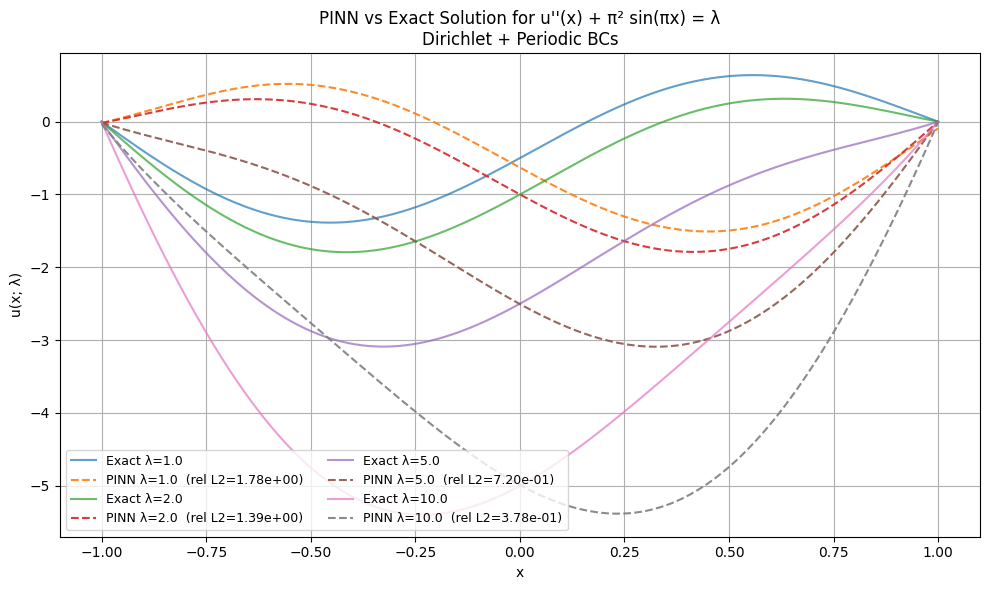

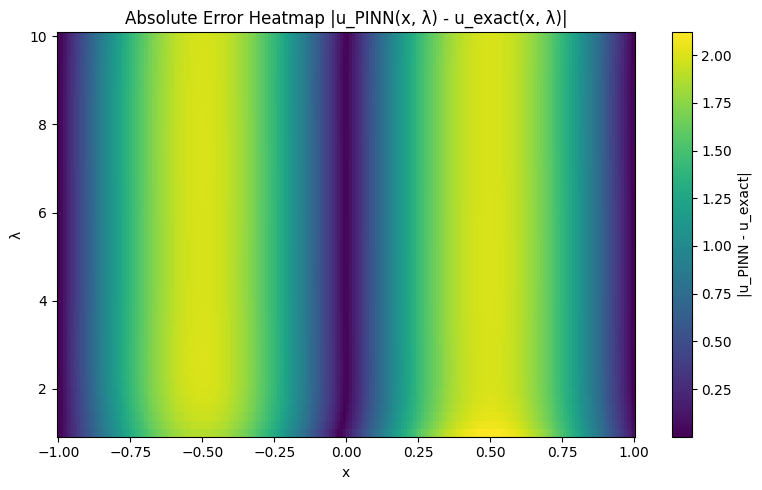

In [36]:
# =========================================================
# Analytical family of exact solutions u(x; λ)
# For: u''(x) + π^2 sin(π x) = λ,  x ∈ [-1, 1]
#      u(-1, λ) = 0,  u(1, λ) = 0
# =========================================================

def exact_family(X):
    """
    Analytical closed-form solution u(x; λ) for the parametric BVP:

        u''(x) + π^2 sin(π x) = λ,     x ∈ [-1, 1]
        u(-1, λ) = 0,
        u(1,  λ) = 0    (in practice enforced via Dirichlet at x = -1
                        plus periodic BC u(-1, λ) = u(1, λ))

    Derivation (sketch):

    1) Rewrite the PDE:

           u''(x) = λ - π^2 sin(π x).

    2) Integrate once:

           u'(x) = λ x + π cos(π x) + C1.

    3) Integrate again:

           u(x) = (λ/2) x^2 + sin(π x) + C1 x + C2.

    4) Apply boundary conditions:

       - At x = -1:

           0 = u(-1, λ)
             = (λ/2)(-1)^2 + sin(-π) + C1(-1) + C2
             = λ/2 - C1 + C2
           ⇒ C2 = C1 - λ/2.

       - At x =  1:

           0 = u(1, λ)
             = (λ/2)(1)^2 + sin(π) + C1(1) + C2
             = λ/2 + C1 + C2.

         Substitute C2 = C1 - λ/2:

             0 = λ/2 + C1 + (C1 - λ/2) = 2 C1
           ⇒ C1 = 0,  C2 = -λ/2.

    5) Final formula:

           u(x; λ) = sin(π x) + (λ/2)(x^2 - 1).

    DeepXDE can use this function to compute pointwise errors and
    relative L2 error over test points for all λ ∈ [1, 10].
    """
    # Extract x and λ from X
    x   = X[:, 0:1]
    lam = X[:, 1:2]

   # u(x; λ) = sin(π x) + (λ/2)(x^2 - 1)
    return np.sin(np.pi * x) + 0.5 * lam * (x**2 - 1.0)


# =========================================================
# 1. PDE definition: parametric Poisson u''(x) + pi^2 sin(pi x)= λ
# =========================================================
def pde(X, y):
    """
    Physics-informed residual for the parametric Poisson problem:

        u''(x) + pi^2 * sin(pi * x) = λ,  x ∈ [-1,1], λ ∈ [1,10]

    DeepXDE passes:
        - X : a tensor of shape (N, 2)
              X[:, 0] = x  coordinates
              X[:, 1] = λ  parameter values
        - y : the network output u(x, λ) of shape (N, 1)

    Our PDE must be written in residual form F(x, λ, u, ...) = 0.
    We choose:

        F = u_xx - pi^2 * sin(pi * x) - λ = 0

    so the PINN will try to make u_xx ≈ λ everywhere in the domain.
    """

    # -----------------------------------------------------------------
    # Split the input into "x" and "λ" coordinates
    # -----------------------------------------------------------------
    # X[:, 0:1] is a column vector of x values, shape (N,1)
    x = X[:, 0:1]

    # X[:, 1:2] is a column vector of λ values, shape (N,1)
    lam = X[:, 1:2]

    # -----------------------------------------------------------------
    # Compute first and second derivatives of u(x, λ) w.r.t. x
    # -----------------------------------------------------------------
    # u_x = ∂u/∂x:
    #   dde.grad.jacobian(y, X, i=0, j=0) means:
    #       "take partial derivative of y (component i=0) w.r.t X (component j=0)"
    #   Since y has only 1 component, i=0 is fine.
    #   Since X has two components [x, λ], j=0 refers to x.
    u_x = dde.grad.jacobian(y, X, i=0, j=0)

    # u_xx = ∂²u/∂x²:
    #   take derivative of u_x w.r.t. x again (same logic, j=0).
    u_xx = dde.grad.jacobian(u_x, X, i=0, j=0)

    # pi^2 * sin(pi * x)
    # sin_term = (np.pi ** 2) * torch.sin(np.pi * x)
    sin_term = (math.pi ** 2) * tf.sin(math.pi * x)

    
    # -----------------------------------------------------------------
    # PDE residual:
    #     u_xx - pi^2 * sin(pi * x) - λ = 0
    #
    # DeepXDE will square this residual, average over collocation points,
    # and include it in the total loss.
    # -----------------------------------------------------------------
    return u_xx - sin_term - lam


# =========================================================
# 2. Boundary conditions
#    u(-1, λ) = 0                (Dirichlet on the left)
#     u(-1, λ) = u(1, λ)         (Periodic boundary condition)
# =========================================================

def boundary_value_left(X):
    """
    Dirichlet boundary value g(x, λ) on the left boundary x = -1.

    For all λ in [1, 10], we want:

        u(-1, λ) = 0

    DeepXDE will call this function for points on the boundary that
    satisfy boundary_left(...). The return value is the target value
    that u should match there.
    """
    return 0.0


def boundary_left(X, on_boundary):
    """
    Indicator function that selects the left boundary x = -1.

    Args:
        X           : array-like with two entries [x, λ]
        on_boundary : bool, True if X lies somewhere on the domain boundary

    Returns:
        True if and only if:
          1) the point is on the boundary, and
          2) its x-coordinate is (numerically) equal to -1.

    dde.utils.isclose() is used instead of a strict equality to allow
    for small floating-point errors.
    """
    # X[0] is x-coordinate, X[1] is λ
    return on_boundary and dde.utils.isclose(X[0], -1.0)


def periodic_boundary(X, on_boundary):
    """
    Select both end points x = -1 and x = 1 for the periodic BC.

    DeepXDE will internally match those two sides so that
        u(-1, λ) = u(1, λ)
    for all λ.
    """
    return on_boundary and (
        dde.utils.isclose(X[0], -1.0) or dde.utils.isclose(X[0], 1.0))



# =========================================================
# Geometry definition: (x, λ) ∈ [-1,1] × [1,10]
# =========================================================

# We define a 2D rectangular domain in the plane (x, λ),
# where:
#   x   ∈ [-1, 1]
#   λ   ∈ [ 1,10]
# xmin and xmax are given as 2D vectors [x_min, λ_min], [x_max, λ_max].
geom = dde.geometry.Rectangle(xmin=[-1.0, 1.0], xmax=[1.0, 10.0])

# Dirichlet boundary condition on the left boundary x = -1:
#   - geom: domain
#   - boundary_value_left: value to enforce u(-1, λ) = 0
#   - boundary_left: function selecting which points are on this boundary
#   - component=0: network output component index (0 for u)
bc_left = dde.icbc.DirichletBC(geom, boundary_value_left, boundary_left)

# Periodic BC in x-direction: u(-1, λ) = u(1, λ)
# Therefore, boundary_value_left is included 
# instead of assigning 'boudnary_value_right' and using it.
bc_periodic = dde.icbc.PeriodicBC(geom, 0, periodic_boundary)

# =========================================================
# DeepXDE data object: PDE + BCs + sampling strategy
# =========================================================
'''
data = dde.data.PDE(
    geom=geom,               # spatial/parameter domain
    pde=pde,                 # PDE residual function
    bc=[bc_left, bc_right],  # list of boundary conditions
    num_domain=64,           # number of random interior collocation points per epoch
    num_boundary=16,         # number of random boundary points per epoch
    solution=exact_family,   # exact solution for error reporting
    num_test=1000            # number of test points sampled for metrics
)
'''
data = dde.data.PDE(
    geom,
    pde,
    [bc_left, bc_periodic],  
    64,
    16,
    solution=exact_family,
    num_test=1000)


# =========================================================
# Neural network architecture: u(x, λ) → ℝ
# =========================================================

# layer_size defines each fully-connected layer:
#   input dimension : 2 (x and λ)
#   hidden layers   : 3 layers with 50 neurons each
#   output dimension: 1 (scalar u)
layer_size = [2] + [50] * 3 + [1]

# Tanh activation function is widely used for PINNs
activation = "tanh"

# "Glorot uniform" (Xavier uniform) weight initialization
initializer = "Glorot uniform"

# Build a fully-connected neural network (FNN) with the given configuration.
# DeepXDE will internally create tf.keras layers with these specs.
net = dde.nn.FNN(layer_size, activation, initializer)




# =========================================================
# 7. Model compilation and training
# =========================================================

# Combine the PDE data object and the neural network into a DeepXDE model
model = dde.Model(data, net)

# Compile the model:
#   - "adam"    : use Adam optimizer
#   - lr=0.001  : learning rate
#   - metrics   : additional metrics to log; here we track relative L2 error
model.compile(
    optimizer="adam",
    lr=0.001,
    metrics=["l2 relative error"]
)

# Train the PINN for 10,000 iterations.
# losshistory    : contains the values of each loss term over iterations
# train_state    : final state, including best model, metrics, etc.
losshistory, train_state = model.train(iterations=10000)



# =========================================================
# Evaluation: compare PINN vs exact for several λ values
# =========================================================

# =========================================================
# 1) Line plots: u(x; λ) for several λ values
# =========================================================

# 1D grid of x-values in [-1, 1]
x_plot = np.linspace(-1, 1, 400).reshape(-1, 1)

# Representative λ values to inspect
lambda_list = [1.0, 2.0, 5.0, 10.0]

plt.figure(figsize=(10, 6))

for lam_val in lambda_list:
    # Build (x, λ) pairs for this λ
    lam_col = lam_val * np.ones_like(x_plot)        # shape (400, 1)
    X_query = np.hstack([x_plot, lam_col])          # shape (400, 2)

    # PINN prediction
    u_pinn = model.predict(X_query)                 # shape (400, 1)

    # Exact analytical solution
    u_exact = exact_family(X_query)                 # shape (400, 1)

    # Relative L2 error for this λ (optional, for legend info)
    rel_l2 = np.linalg.norm(u_pinn - u_exact) / np.linalg.norm(u_exact)

    # Plot PINN and exact curves
    plt.plot(
        x_plot,
        u_exact,
        "-",
        alpha=0.7,
        label=f"Exact λ={lam_val:.1f}"
    )
    plt.plot(
        x_plot,
        u_pinn,
        "--",
        alpha=0.9,
        label=f"PINN λ={lam_val:.1f}  (rel L2={rel_l2:.2e})"
    )

plt.xlabel("x")
plt.ylabel("u(x; λ)")
plt.title("PINN vs Exact Solution for u''(x) + π² sin(πx) = λ\nDirichlet + Periodic BCs")
plt.grid(True)
plt.legend(ncol=2, fontsize=9)
plt.tight_layout()
plt.show()


# =========================================================
# 2) 2D heatmap: |u_PINN - u_exact| over (x, λ)
# =========================================================

# Finer grid in x and λ for a global view
x_vals = np.linspace(-1, 1, 200)
lam_vals = np.linspace(1, 10, 50)

X_grid, Lam_grid = np.meshgrid(x_vals, lam_vals)   # shapes (50, 200)

# Flatten to (N, 2) for model.predict / exact_family
X_flat = X_grid.ravel().reshape(-1, 1)
Lam_flat = Lam_grid.ravel().reshape(-1, 1)
X_query_all = np.hstack([X_flat, Lam_flat])        # shape (50*200, 2)

# PINN prediction on the whole (x, λ) grid
u_pinn_all = model.predict(X_query_all)            # shape (N, 1)
u_exact_all = exact_family(X_query_all)            # shape (N, 1)

# Absolute error and reshape back to (λ, x) grid
err_all = np.abs(u_pinn_all - u_exact_all).reshape(Lam_grid.shape)

plt.figure(figsize=(8, 5))
im = plt.pcolormesh(
    X_grid,
    Lam_grid,
    err_all,
    shading="auto"
)
plt.colorbar(im, label="|u_PINN - u_exact|")
plt.xlabel("x")
plt.ylabel("λ")
plt.title("Absolute Error Heatmap |u_PINN(x, λ) - u_exact(x, λ)|")
plt.tight_layout()
plt.show()